In [28]:
# Economic Indicators Regression Analysis
# Este notebook carga los datos económicos consolidados de México desde Athena
# y realiza análisis de regresión lineal entre los indicadores clave

# Importamos las bibliotecas necesarias
import boto3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import io
from datetime import datetime

In [29]:
# Definimos las constantes
BUCKET_NAME = "itam-analytics-ragp"
DATABASE_NAME = "econ"
TABLE_NAME = "indicadores_economicos_consolidados"
PROFILE_NAME = "datascientist"

In [30]:
def conectar_athena():
    """
    Establece conexión con AWS Athena usando el perfil especificado.
    """
    try:
        # Creamos una sesión usando el perfil
        session = boto3.Session(profile_name=PROFILE_NAME)
        
        # Creamos el cliente Athena
        athena_client = session.client('athena')
        
        print(f"✅ Conexión establecida con AWS Athena.")
        return athena_client
    
    except Exception as e:
        print(f"❌ Error al conectar con AWS Athena: {str(e)}")
        return None

In [31]:
def obtener_datos_consolidados(athena_client):
    """
    Ejecuta una consulta en Athena para obtener todos los datos de la tabla consolidada
    y los devuelve como un DataFrame.
    """
    s3_resultados = f"s3://arquitectura-athena-queries-ragp/"
    
    try:
        # Consulta para obtener todos los datos
        consulta = f"""
        SELECT 
            date, 
            tasa_de_interes, 
            inflacion, 
            tipo_de_cambio
        FROM 
            {DATABASE_NAME}.{TABLE_NAME}
        ORDER BY 
            date
        """
        
        # Iniciamos la ejecución de la consulta
        response = athena_client.start_query_execution(
            QueryString=consulta,
            QueryExecutionContext={
                'Database': DATABASE_NAME
            },
            ResultConfiguration={
                'OutputLocation': s3_resultados,
            }
        )
        
        query_execution_id = response['QueryExecutionId']
        print(f"✅ Consulta iniciada con ID: {query_execution_id}")
        
        # Esperamos a que la consulta se complete
        estado = 'RUNNING'
        print("⏳ Consultando datos...", end="", flush=True)
        import time
        while estado in ['RUNNING', 'QUEUED']:
            time.sleep(1)
            response = athena_client.get_query_execution(QueryExecutionId=query_execution_id)
            estado = response['QueryExecution']['Status']['State']
            if estado == 'RUNNING':
                print(".", end="", flush=True)
        print("\n")
        
        # Verificamos el resultado final
        if estado == 'SUCCEEDED':
            # Obtenemos los resultados directamente
            paginator = athena_client.get_paginator('get_query_results')
            
            # Preparamos listas para almacenar los datos
            columns = []
            rows = []
            
            # Iteramos por los resultados paginados
            for page in paginator.paginate(QueryExecutionId=query_execution_id):
                # Si es la primera página, obtenemos los nombres de las columnas
                if not columns:
                    columns = [col['Label'] for col in page['ResultSet']['ResultSetMetadata']['ColumnInfo']]
                
                # Procesamos las filas (omitimos la primera página si contiene los encabezados)
                start_index = 1 if columns and not rows else 0
                
                for row in page['ResultSet']['Rows'][start_index:]:
                    rows.append([item.get('VarCharValue', None) for item in row['Data']])
            
            # Creamos el DataFrame
            df = pd.DataFrame(rows, columns=columns)
            
            # Convertimos tipos de datos
            df['date'] = pd.to_datetime(df['date'])
            df['tasa_de_interes'] = pd.to_numeric(df['tasa_de_interes'])
            df['inflacion'] = pd.to_numeric(df['inflacion'])
            df['tipo_de_cambio'] = pd.to_numeric(df['tipo_de_cambio'])
            
            print(f"✅ Datos obtenidos exitosamente: {len(df)} registros")
            print(f"   Período: {df['date'].min().strftime('%Y-%m-%d')} a {df['date'].max().strftime('%Y-%m-%d')}")
            
            return df
            
        else:
            error_info = response['QueryExecution']['Status'].get('StateChangeReason', 'Desconocido')
            print(f"❌ La consulta falló: {estado} - {error_info}")
            return None
            
    except Exception as e:
        print(f"❌ Error al obtener datos: {str(e)}")
        return None

In [32]:
def realizar_regresion(df, var_dep, var_indep, titulo):
    """
    Realiza un análisis de regresión lineal entre dos variables.
    
    Args:
        df: DataFrame con los datos
        var_dep: Nombre de la variable dependiente (Y)
        var_indep: Nombre de la variable independiente (X)
        titulo: Título para el gráfico
    
    Returns:
        Resultados del modelo de regresión
    """
    # Preparamos los datos
    X = df[var_indep]
    X = sm.add_constant(X)  # Añadimos constante (intercepto)
    y = df[var_dep]
    
    # Construimos y ajustamos el modelo
    model = sm.OLS(y, X).fit()
    
    # Obtenemos predicciones y residuos
    predictions = model.predict(X)
    residuals = y - predictions
    
    # Imprimimos el resumen del modelo
    print(f"\n📈 RESULTADOS DE REGRESIÓN: {var_dep} ~ {var_indep}")
    print("=" * (len(f"RESULTADOS DE REGRESIÓN: {var_dep} ~ {var_indep}") + 3))
    print(model.summary())
    
    # Visualizamos los resultados
    plt.figure(figsize=(14, 10))
    
    # 1. Scatter plot con línea de regresión
    plt.subplot(2, 2, 1)
    plt.scatter(df[var_indep], df[var_dep], alpha=0.5)
    plt.plot(df[var_indep], predictions, 'r-', linewidth=2)
    plt.title(f'Regresión Lineal: {titulo}')
    plt.xlabel(var_indep.replace('_', ' ').title())
    plt.ylabel(var_dep.replace('_', ' ').title())
    plt.grid(True)
    
    # 2. Distribución de residuos
    plt.subplot(2, 2, 2)
    sns.histplot(residuals, kde=True)
    plt.title('Distribución de Residuos')
    plt.xlabel('Residuos')
    plt.grid(True)
    
    # 3. Q-Q plot para verificar normalidad
    plt.subplot(2, 2, 3)
    sm.qqplot(residuals, line='45', fit=True, ax=plt.gca())
    plt.title('Q-Q Plot de Residuos')
    plt.grid(True)
    
    # 4. Gráfico de residuos vs. predicciones
    plt.subplot(2, 2, 4)
    plt.scatter(predictions, residuals, alpha=0.5)
    plt.axhline(y=0, color='r', linestyle='-')
    plt.title('Residuos vs. Valores Ajustados')
    plt.xlabel('Valores Ajustados')
    plt.ylabel('Residuos')
    plt.grid(True)
    
    plt.tight_layout()
    plt.savefig(f'regresion_{var_dep}_vs_{var_indep}.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    return model

In [33]:
"""
Función principal que ejecuta todo el análisis de regresión.
"""
print(f"🔍 Iniciando análisis de regresión de indicadores económicos - {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

# Conectamos con Athena
athena_client = conectar_athena()
if not athena_client:
    print("❌ No se pudo establecer conexión con AWS Athena. Abortando proceso.")


# Obtenemos los datos consolidados
df = obtener_datos_consolidados(athena_client)
if df is None or len(df) == 0:
    print("❌ No se pudieron obtener los datos. Abortando proceso.")

🔍 Iniciando análisis de regresión de indicadores económicos - 2025-03-19 10:14:31
✅ Conexión establecida con AWS Athena.
✅ Consulta iniciada con ID: 19078415-ce41-4c0e-a16f-ba25adcc0115
⏳ Consultando datos...

✅ Datos obtenidos exitosamente: 240 registros
   Período: 2004-12-01 a 2024-11-01



⏳ Ejecutando análisis de regresión...

📈 RESULTADOS DE REGRESIÓN: tipo_de_cambio ~ tasa_de_interes
                            OLS Regression Results                            
Dep. Variable:         tipo_de_cambio   R-squared:                       0.008
Model:                            OLS   Adj. R-squared:                  0.004
Method:                 Least Squares   F-statistic:                     1.994
Date:                Wed, 19 Mar 2025   Prob (F-statistic):              0.159
Time:                        10:14:33   Log-Likelihood:                -654.14
No. Observations:                 240   AIC:                             1312.
Df Residuals:                     238   BIC:                             1319.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
--------------------------

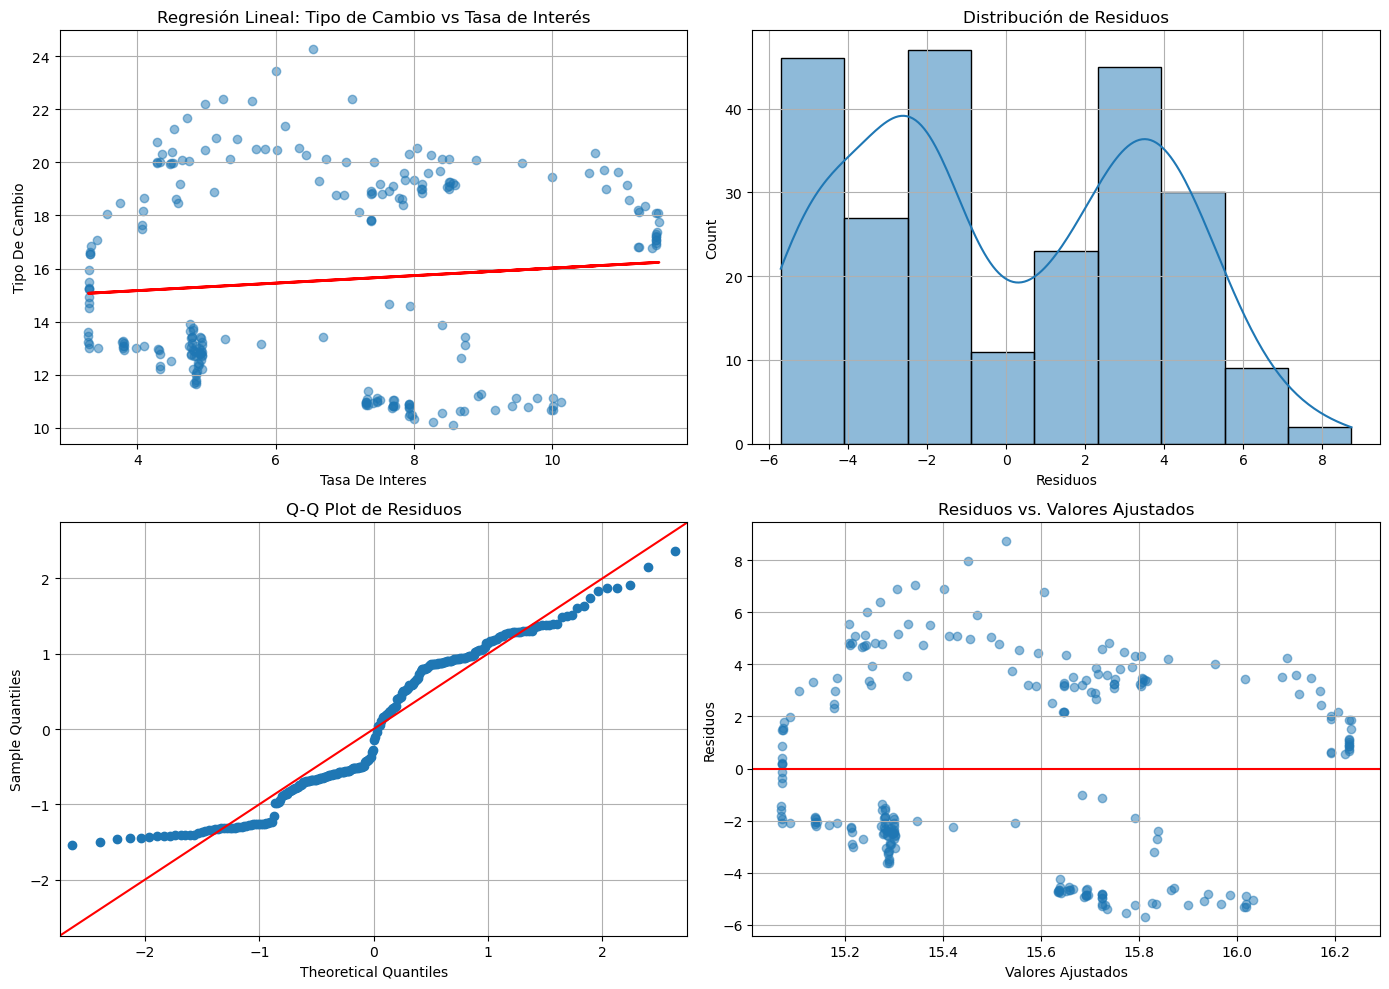

In [34]:
# Realizamos las tres regresiones solicitadas
print("\n⏳ Ejecutando análisis de regresión...")

# 1. tipo_de_cambio ~ tasa_de_interes
modelo1 = realizar_regresion(
    df, 
    var_dep='tipo_de_cambio', 
    var_indep='tasa_de_interes', 
    titulo='Tipo de Cambio vs Tasa de Interés'
)


📈 RESULTADOS DE REGRESIÓN: tasa_de_interes ~ inflacion
                            OLS Regression Results                            
Dep. Variable:        tasa_de_interes   R-squared:                       0.023
Model:                            OLS   Adj. R-squared:                  0.019
Method:                 Least Squares   F-statistic:                     5.613
Date:                Wed, 19 Mar 2025   Prob (F-statistic):             0.0186
Time:                        10:14:34   Log-Likelihood:                -547.30
No. Observations:                 240   AIC:                             1099.
Df Residuals:                     238   BIC:                             1106.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------

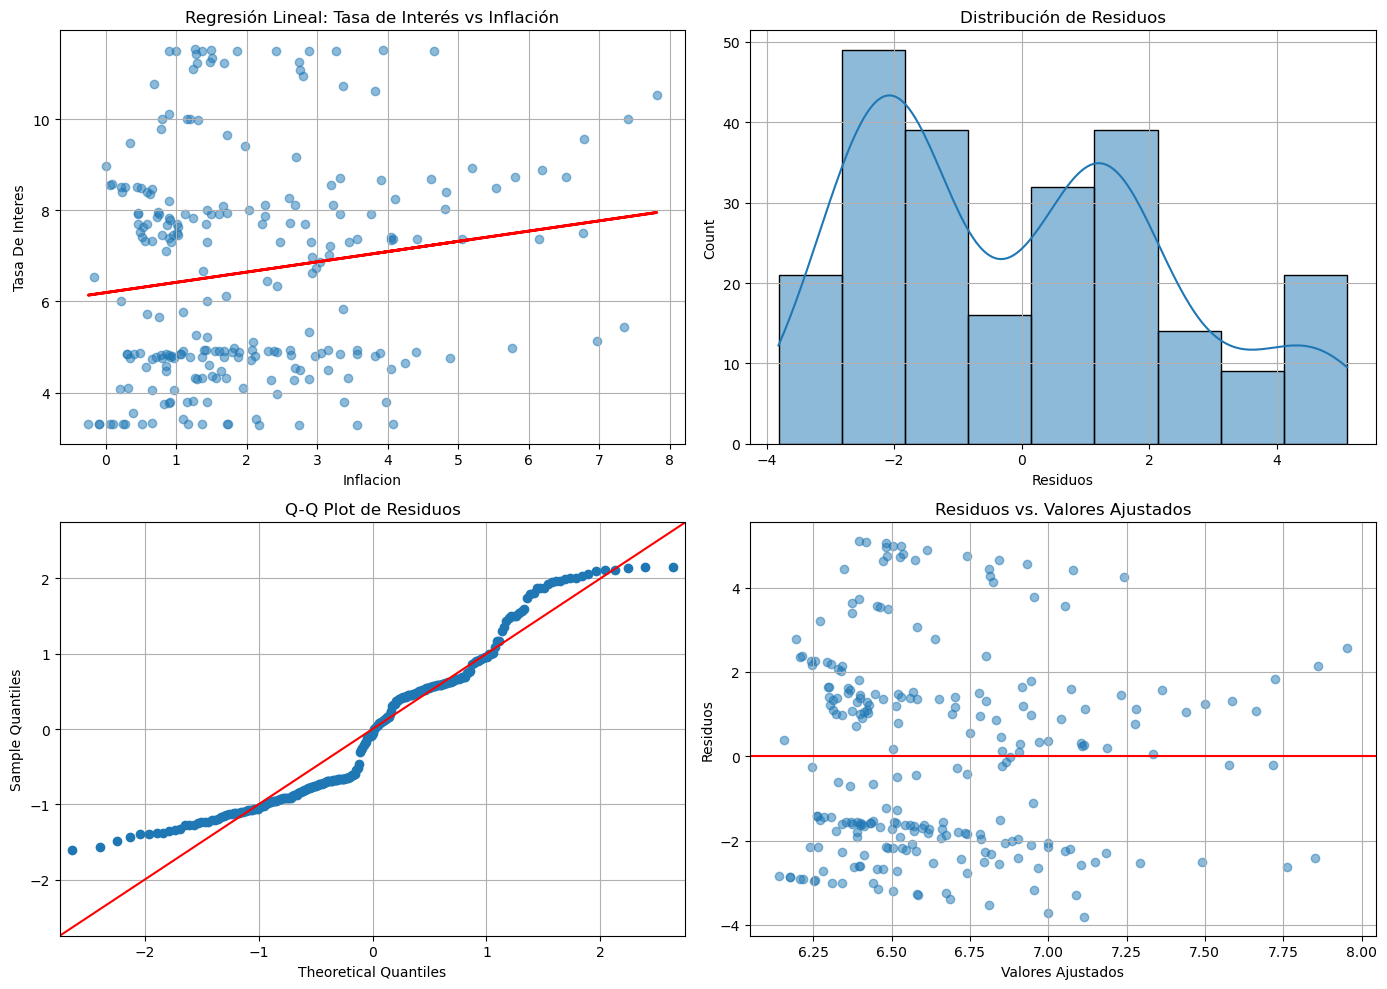

In [35]:
# 2. tasa_de_interes ~ inflacion
modelo2 = realizar_regresion(
    df, 
    var_dep='tasa_de_interes', 
    var_indep='inflacion', 
    titulo='Tasa de Interés vs Inflación'
)


📈 RESULTADOS DE REGRESIÓN: tipo_de_cambio ~ inflacion
                            OLS Regression Results                            
Dep. Variable:         tipo_de_cambio   R-squared:                       0.043
Model:                            OLS   Adj. R-squared:                  0.039
Method:                 Least Squares   F-statistic:                     10.67
Date:                Wed, 19 Mar 2025   Prob (F-statistic):            0.00125
Time:                        10:14:35   Log-Likelihood:                -649.88
No. Observations:                 240   AIC:                             1304.
Df Residuals:                     238   BIC:                             1311.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------

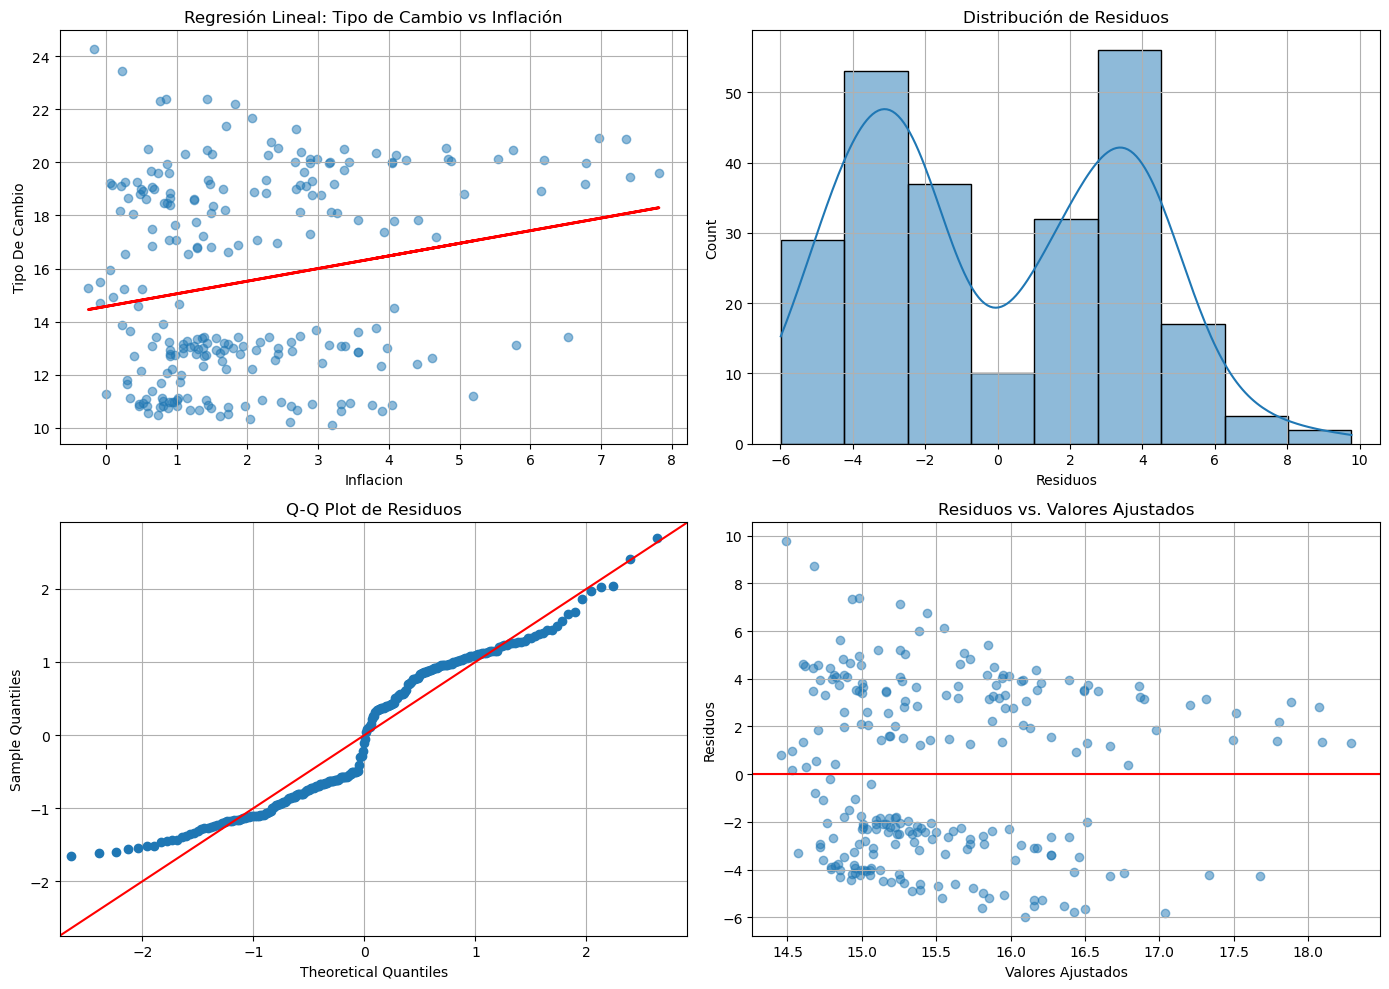

In [36]:
# 3. tipo_de_cambio ~ inflacion
modelo3 = realizar_regresion(
    df, 
    var_dep='tipo_de_cambio', 
    var_indep='inflacion', 
    titulo='Tipo de Cambio vs Inflación'
)


In [37]:
    
# Preparamos un resumen comparativo
print("\n📊 RESUMEN COMPARATIVO DE MODELOS")
print("================================")

modelos = {
    "Tipo de Cambio ~ Tasa de Interés": modelo1,
    "Tasa de Interés ~ Inflación": modelo2,
    "Tipo de Cambio ~ Inflación": modelo3
}

# Creamos un DataFrame con métricas clave
metricas = pd.DataFrame({
    'Modelo': list(modelos.keys()),
    'R²': [modelo.rsquared for modelo in modelos.values()],
    'R² Ajustado': [modelo.rsquared_adj for modelo in modelos.values()],
    'Estadístico F': [modelo.fvalue for modelo in modelos.values()],
    'P-valor (F)': [modelo.f_pvalue for modelo in modelos.values()],
    'AIC': [modelo.aic for modelo in modelos.values()],
    'BIC': [modelo.bic for modelo in modelos.values()]
})

print(metricas)


📊 RESUMEN COMPARATIVO DE MODELOS
                             Modelo        R²  R² Ajustado  Estadístico F  \
0  Tipo de Cambio ~ Tasa de Interés  0.008308     0.004141       1.993790   
1       Tasa de Interés ~ Inflación  0.023041     0.018936       5.612981   
2        Tipo de Cambio ~ Inflación  0.042908     0.038887      10.669978   

   P-valor (F)          AIC          BIC  
0     0.159251  1312.277125  1319.238403  
1     0.018627  1098.609728  1105.571006  
2     0.001249  1303.753866  1310.715143  
